# **Modelos de regresión**

En este trabajo se presentan diversos modelos de regresión con el objetivo de predecir la velocidad del viento utilizando datos históricos. La predicción de variables continuas, como en este caso la velocidad del viento, es un desafío clave en muchos ámbitos, desde la meteorología hasta la energía renovable. Para abordar este problema, se han implementado y evaluado varios enfoques de aprendizaje automático.

## **Librerías y modulos necesarios**

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from scipy.stats import jarque_bera
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

## **Datos**

Inicialmente importamos el conjunto de datos que utilizaremos para el desarrollo de los modelos.

In [3]:
file_path = r'C:\Users\kamac\OneDrive\Desktop\MachineLearningUN\EDA\ws_modelos.xlsx'
data = pd.read_excel(file_path)

### **Características principales de la base de datos**

Aquí podemos ver las primeras cinco filas de nuestro dataset, que será utilizado para la construcción de los modelos de regresión lineal.

In [4]:
data.head()

,Fecha,VelViento100m_1,VelViento100m_2,VelViento80m_1,VelViento80m_2,VelViento60m,DirViento60m,DirViento100m,DirViento80m,Presion,Humedad,Temp100m,Temp21m
0,2022-01-01 00:00:00,16.060860,15.830104,15.145418,15.125038,14.300989,61.98,61.08,61.21,1005.963541,75.042725,26.922913,26.707773
1,2022-01-01 00:10:00,16.156927,15.972642,15.290614,15.352352,14.533556,62.29,61.08,61.49,1005.795867,73.509216,27.006836,26.772633
2,2022-01-01 00:20:00,16.473571,16.287375,15.599149,15.562022,14.808378,61.18,60.42,60.65,1005.739976,72.914124,26.991577,26.772633
3,2022-01-01 00:30:00,16.660009,16.451707,15.801446,15.779687,15.170287,62.20,60.88,61.19,1005.684085,73.165894,26.877136,26.659982
4,2022-01-01 00:40:00,16.519613,16.353678,15.851963,15.749131,14.927282,61.26,59.99,60.26,1005.609563,73.791504,26.770325,26.601949


In [5]:
data.shape

(19105, 13)

El conjunto de datos cuenta con **13** variables y **19105** observaciones.

## **Modelos**
Ahora, veamos los modelos. Dado que nuestro objetivo es predecir la velocidad del viento, y encontramos varias variables objetivo (específicamente 5), que corresponden a las velocidades del viento medidas a diferentes alturas y con diferentes sensores, realizaremos los 4 modelos de regresión seleccionados: Regresión K-NN, Regresión Ridge, Regresión Lasso y Regresión Lineal para cada una de las variables objetivo identificadas.

Para evaluar el desempeño de los modelos, utilizaremos varias métricas, entre ellas el Mean Absolute Percentage Error (MAPE), que nos permitirá medir el error porcentual promedio entre los valores predichos y los valores reales. Esto es especialmente útil cuando se trata de comparaciones de modelos de predicción, ya que el MAPE es intuitivo y fácil de interpretar.

El código para calcular el MAPE se presenta a continuación:

In [7]:
def MAPE(y_true, y_pred):
    # Convertimos las entradas a arrays de numpy para facilitar el cálculo vectorizado
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Evitar la división por cero, ignorando los valores donde y_true es 0
    # Creamos un filtro para seleccionar solo los índices donde y_true no sea igual a 0
    non_zero_indices = y_true != 0

    # Calculamos el MAPE solo para los valores donde y_true no es cero.
    # La fórmula del MAPE es el promedio del valor absoluto del error porcentual entre y_true y y_pred
    # Multiplicamos por 100 para convertirlo en porcentaje
    mape = np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

    # Retornamos el valor del MAPE
    return mape

Este método garantiza que los valores donde el valor verdadero es cero no se incluyan en el cálculo, evitando errores de división por cero y proporcionando una evaluación más precisa del desempeño de los modelos. A continuación, aplicaremos esta métrica, junto con otras como el $RMSE$ y el $R^2$, para evaluar el desempeño de cada uno de los modelos en las distintas variables objetivo.

### **Método para evaluar los modelos usando ventanas de predicción**

A continuación, se presenta la función evaluar_modelos, que nos permite entrenar y evaluar varios modelos de regresión para predecir la velocidad del viento, utilizando ventanas temporales de distintos tamaños (7, 14, 21 y 28 días). La función implementa cuatro modelos principales: **Regresión K-NN**, **Regresión Lineal**, **Regresión Ridge** y **Regresión Lasso**. Cada uno de estos modelos se evalúa utilizando métricas clave como **RMSE, MAPE y $R^2$**, junto con pruebas estadísticas adicionales como el test de **Jarque-Bera** y **Ljung-Box** para evaluar la normalidad y autocorrelación de los residuos.

La evaluación se realiza en bloques de entrenamiento y prueba definidos por las ventanas de tiempo, lo que permite una estimación más robusta de su capacidad predictiva. A continuación, se presenta el código correspondiente para esta evaluación.

In [8]:
def evaluar_modelos(X, y, ventanas_tiempo=[7, 14, 21, 28]):
    modelos = {
        'Regresión K-NN': KNeighborsRegressor(),
        'Regresión Lineal': LinearRegression(),
        'Regresión Ridge': Ridge(),
        'Regresión Lasso': Lasso(alpha = 0.011)
    }

    indices_modelos = {
        'Regresión K-NN': {'index': 0},
        'Regresión Lineal': {'index': 1},
        'Regresión Ridge': {'index': 2},
        'Regresión Lasso': {'index': 3}
    }

    mejores = [None] * 4
    menor_RMSE = [1000] * 4
    resultados = []

    for ventana in ventanas_tiempo:
        inicio = 0

        while inicio + (ventana * 6 * 24) + (6 * 24) < len(X):
            fin = inicio + (ventana * 6 * 24)
            if fin > len(X) or fin + (6 * 24) > len(X):
                break

            X_train, y_train = X.iloc[inicio:fin], y.iloc[inicio:fin]
            X_test, y_test = X.iloc[fin:fin + (6 * 24)], y.iloc[fin:fin + (6 * 24)]

            # Iterar sobre cada modelo
            for nombre_modelo, modelo in modelos.items():
                idx = indices_modelos[nombre_modelo]['index']

                modelo.fit(X_train, y_train)
                y_pred, y_train_pred = modelo.predict(X_test), modelo.predict(X_train)

                residuals = y_test - y_pred
                RMSE = mean_squared_error(y_test, y_pred, squared=False)
                MAPE_value = MAPE(y_test, y_pred)
                R2 = r2_score(y_test, y_pred)

                jb_test_stat, jb_p_value = jarque_bera(residuals)
                lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
                ljung_box_p_value = lb_test['lb_pvalue'].values[0]

                # Actualizar si este modelo tiene menor RMSE
                if RMSE < menor_RMSE[idx]:
                    mejores[idx], menor_RMSE[idx] = [y_train, y_train_pred, y_test, y_pred, nombre_modelo], RMSE

                # Almacenar los resultados para cada modelo
                resultados.append({
                    "Modelo": nombre_modelo,
                    "MAPE": MAPE_value,
                    "RMSE": RMSE,
                    "R^2": R2,
                    "Ljung-Box p-value": ljung_box_p_value,
                    "Jarque-Bera p-value": jb_p_value
                })

            inicio = fin

    # Convertir resultados a DataFrame
    resultados_df = pd.DataFrame(resultados)

    # Seleccionar los mejores modelos según RMSE
    mejores_modelos = resultados_df.loc[resultados_df.groupby('Modelo')['RMSE'].idxmin()]

    return mejores_modelos, mejores


### **Método para realizar las gráficas**

In [9]:
def grafica(y_train, y_train_pred, y_test, y_test_pred, nombre_modelo):
    # Calcular R² y RMSE para el conjunto de entrenamiento
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    plt.figure(figsize=(14, 6))

    # Gráfico del conjunto de entrenamiento
    plt.subplot(1, 2, 1)
    plt.plot(range(len(y_train)), y_train, label='Velocidad original', color='#FF69B4', linestyle='-', marker='o')  # Rosa brillante
    plt.plot(range(len(y_train_pred)), y_train_pred, label='Velocidad predicha', color='#FF1493', linestyle='--', marker='x')  # Rosa oscuro
    plt.xlabel('Índice')
    plt.ylabel('Velocidad del viento')
    plt.title(f"{nombre_modelo} (Entrenamiento)\nR²: {r2_train:.5f}")
    plt.legend()
    plt.grid(True)

    # Gráfico del conjunto de prueba
    plt.subplot(1, 2, 2)
    plt.plot(range(len(y_test)), y_test, label='Velocidad original', color='#FFB6C1', linestyle='-', marker='o')  # Rosa claro
    plt.plot(range(len(y_test_pred)), y_test_pred, label='Velocidad predicha', color='#DB7093', linestyle='--', marker='x')  # Rosa medio
    plt.xlabel('Índice')
    plt.ylabel('Velocidad del viento')
    plt.title(f"{nombre_modelo} (Prueba)\nR²: {r2_test:.5f}")
    plt.legend()
    plt.grid(True)

    return plt

## **Modelo 1: Wind speed 100 metros (Sensor 1)**

In [11]:
X1 = data.drop(columns=['Fecha', 'VelViento100m_1', 'VelViento100m_2', 'VelViento80m_1', 'VelViento80m_2', 'VelViento60m', 'DirViento80m', 'DirViento60m'])
y1 = data['VelViento100m_1']

### **Modelos usando ventanas de predicción**

In [ ]:
tabla, mejores = evaluar_modelos(X1, y1)
tabla

,Modelo,MAPE,RMSE,R^2,Ljung-Box p-value,Jarque-Bera p-value
24,Regresión K-NN,5.894020,1.227196,0.510433,1.169459e-22,0.000070
27,Regresión Lasso,4.030474,0.851866,0.764100,3.756088e-67,0.219406
25,Regresión Lineal,4.013425,0.845024,0.767875,1.306806e-63,0.248818
26,Regresión Ridge,4.013893,0.846827,0.766883,7.620692e-65,0.241076


En esta sección se analizan los modelos utilizando el sensor 1 a 100 metros de altura. Los modelos de **Regresión Lasso** y **Ridge** destacan con los menores valores de **MAPE** (aproximadamente **4%**), indicando que sus predicciones están más cerca de los valores reales. También muestran los valores más bajos de **RMSE**, alrededor de **0.85**, lo que sugiere mejor precisión. En términos de **R²**, ambos tienen valores altos, entre **0.764 y 0.766**, lo que indica que capturan bien la variabilidad en los datos. Aunque K-NN presenta un **Ljung-Box p-value** bajo, sugiriendo autocorrelación en los residuos, Lasso, Lineal y Ridge tienen p-valores más favorables. Además, el **Jarque-Bera p-value** revela que K-NN no sigue una distribución normal, mientras que los otros modelos muestran un mejor comportamiento. En conclusión, **Lasso** y **Ridge** son las mejores opciones para predecir la velocidad del viento en este análisis.

### **Gráfica del mejor modelo**

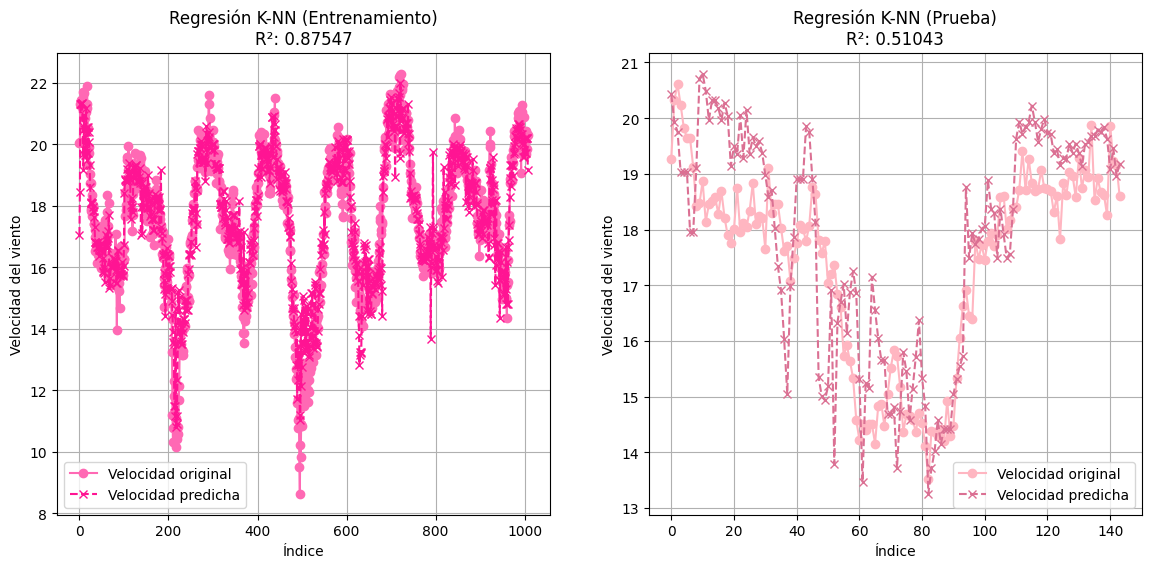

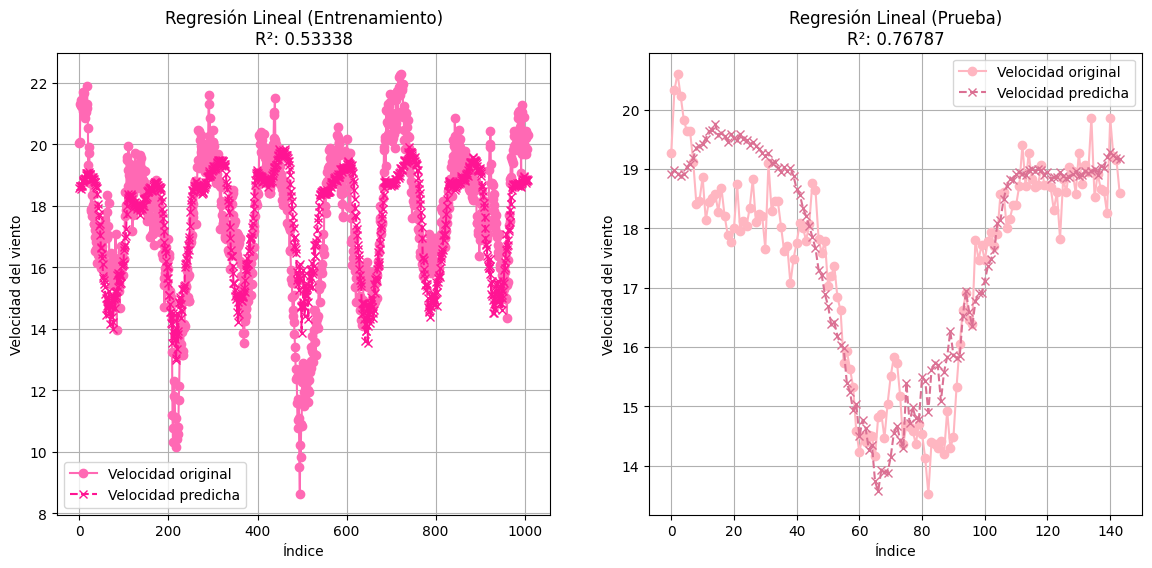

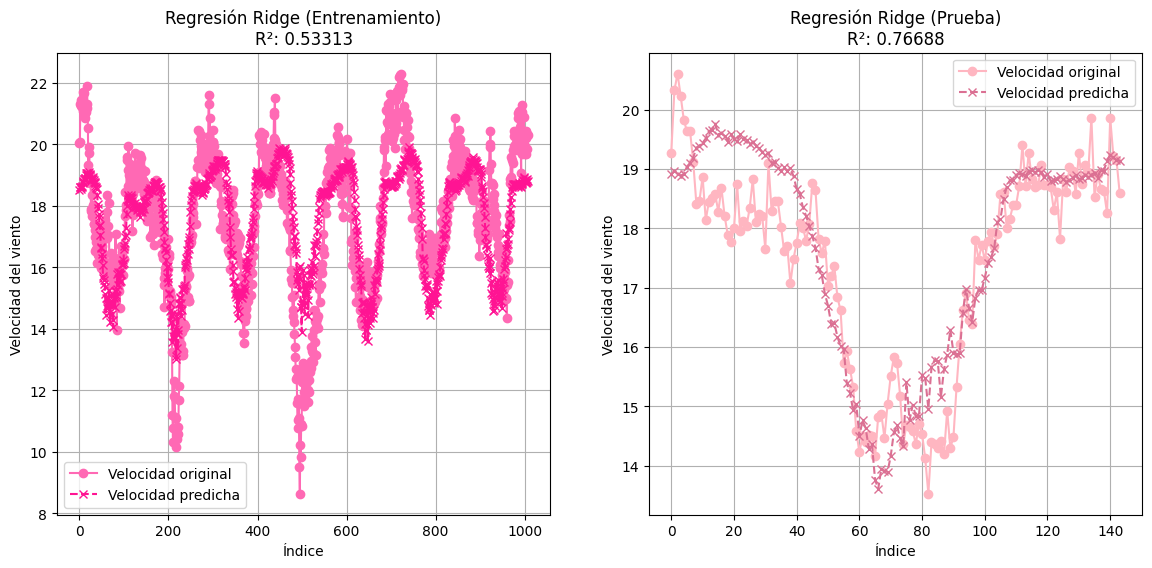

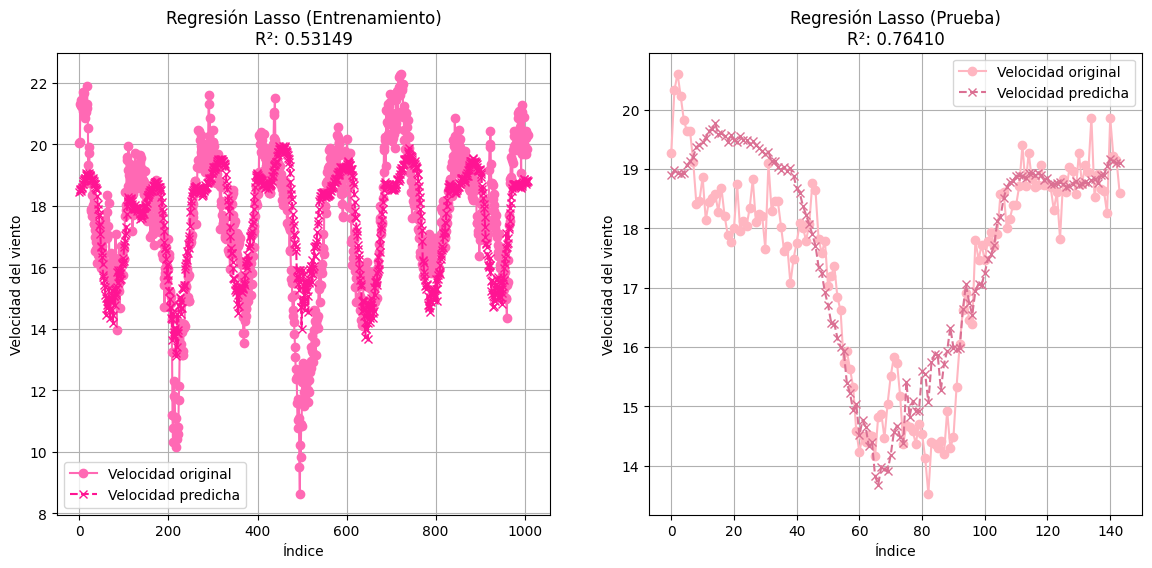

In [ ]:
for i in range(4):
    plt = grafica(mejores[i][0], mejores[i][1], mejores[i][2], mejores[i][3], mejores[i][4])
    plt.show()

La gráfica muestra que el modelo K-NN tiene un buen ajuste en el conjunto de entrenamiento, con un **R² de 0.87547**, lo que indica que predice con precisión los datos de entrenamiento. Sin embargo, en el conjunto de prueba, el rendimiento disminuye significativamente, con un **R² de 0.51043**, lo que sugiere que el modelo no generaliza bien y está posiblemente sobreajustado. Esto es común cuando se utilizan modelos que no son adecuados para capturar dependencias temporales, como el K-NN en series de tiempo.

## **Modelo 2: Wind speed 100 metros (Sensor 2)**

### **Modelos usando ventanas de predicción**


In [12]:
X2 = data.drop(columns=['Fecha', 'VelViento100m_1', 'VelViento100m_2', 'VelViento80m_1', 'VelViento80m_2', 'VelViento60m', 'DirViento80m', 'DirViento60m'])
y2 = data['VelViento100m_2']


In [ ]:
tabla, mejores = evaluar_modelos(X2, y2)
tabla

,Modelo,MAPE,RMSE,R^2,Ljung-Box p-value,Jarque-Bera p-value
24,Regresión K-NN,5.832642,1.204380,0.517706,8.404607e-23,0.000114
27,Regresión Lasso,4.015778,0.837676,0.766688,3.521004e-67,0.173372
25,Regresión Lineal,3.996092,0.830596,0.770615,1.214976e-63,0.198714
26,Regresión Ridge,3.996013,0.832460,0.769584,7.349954e-65,0.191579


En esta sección se evalúan los modelos utilizando el sensor 2, correspondiente a 100 metros de altura. El modelo de **Regresión Lasso** muestra el mejor desempeño, con un **RMSE bajo de 0.837676** y un **R² de 0.766688**, lo que indica una buena capacidad predictiva. Además, tiene un **MAPE** de aproximadamente **4%**, lo que sugiere que sus predicciones son relativamente precisas. Tanto la **Regresión Ridge** como la **Regresión Lineal** presentan resultados similares, con valores de **R² cercanos a 0.76**, lo que indica que también son buenos modelos para predecir esta variable. En contraste, el modelo **K-NN** muestra un **MAPE elevado de 5.83%** y un menor **R² de 0.517706**, lo que lo hace menos efectivo en la predicción de los datos. En resumen, los modelos lineales como Lasso y Ridge superan claramente a K-NN en precisión y capacidad predictiva para esta variable objetivo.

### **Gráficas**

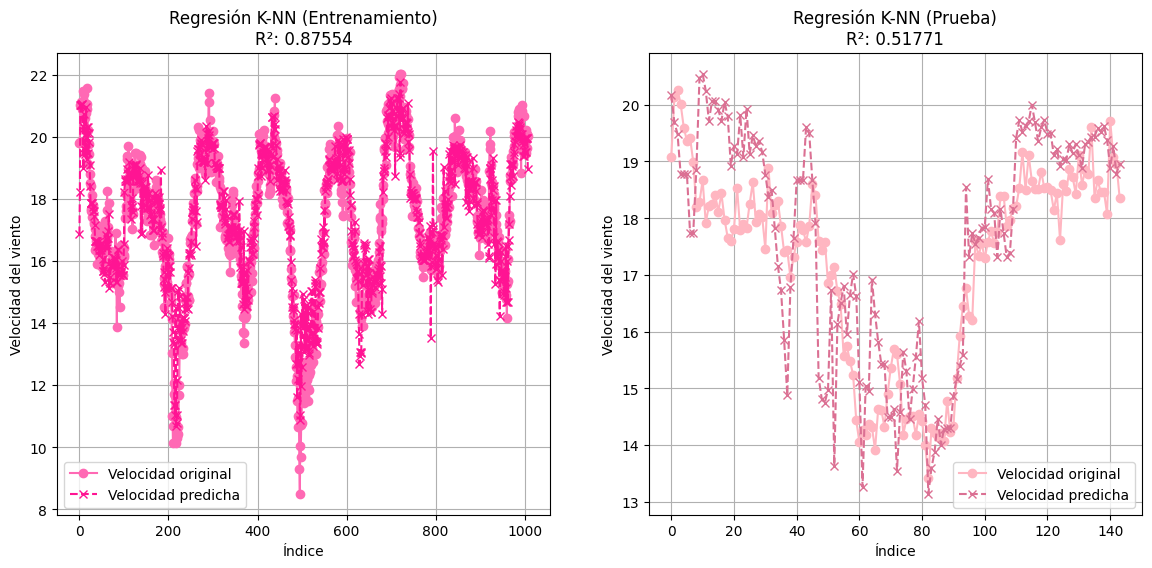

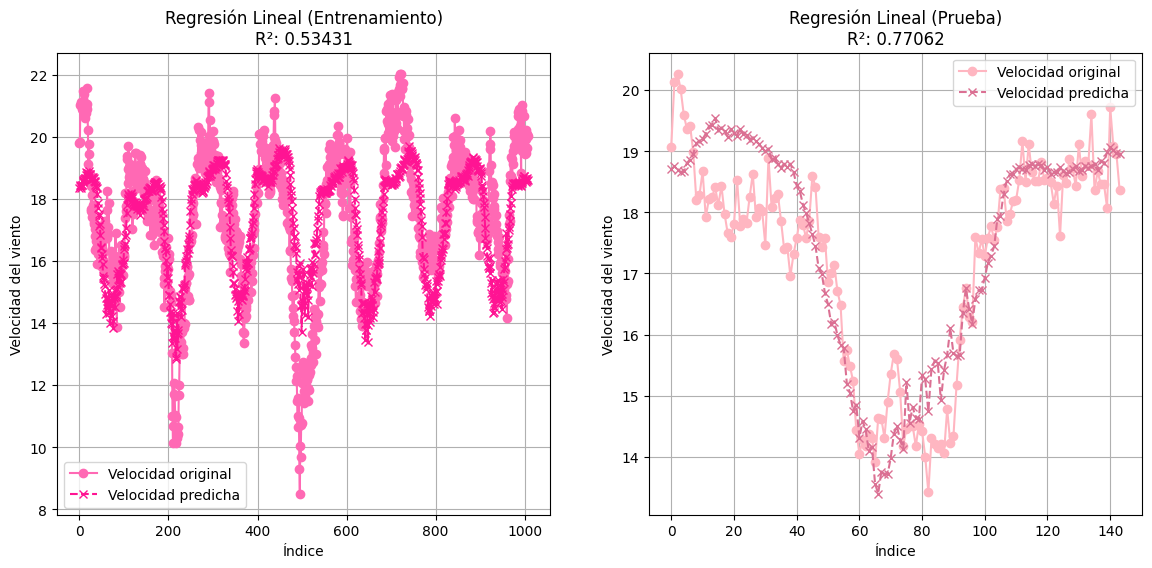

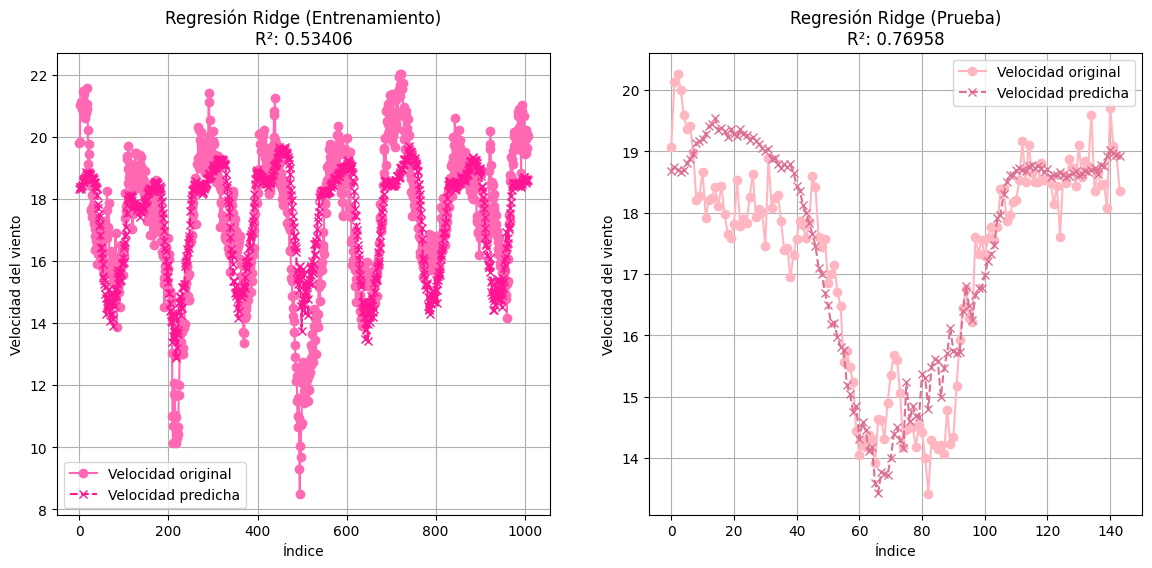

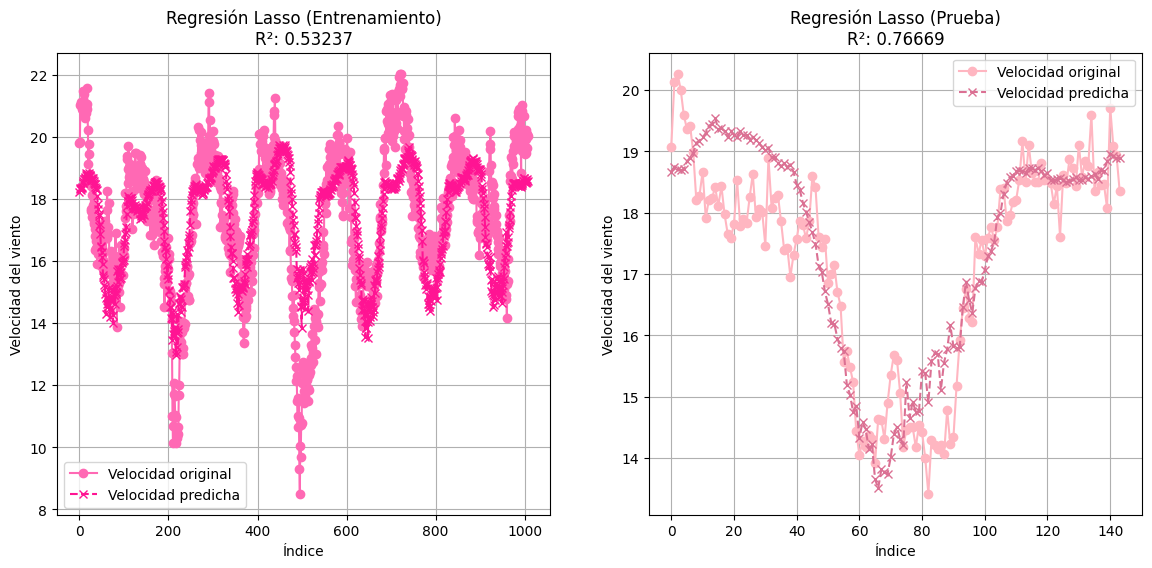

In [ ]:
for i in range(4):
    plt = grafica(mejores[i][0], mejores[i][1], mejores[i][2], mejores[i][3], mejores[i][4])
    plt.show()

La gráfica muestra el desempeño del modelo de **Regresión K-NN** para la predicción de la velocidad del viento, comparando el conjunto de entrenamiento (izquierda) con el de prueba (derecha). En el conjunto de entrenamiento, el modelo presenta un **R² de 0.87554**, indicando un buen ajuste, ya que las predicciones (cruces) siguen de cerca los valores reales (puntos). Sin embargo, este alto rendimiento puede ser un signo de **sobreajuste**, dado que K-NN es muy sensible a los datos de entrenamiento. Por otro lado, en el conjunto de prueba, el rendimiento del modelo es significativamente menor, con un **R² de 0.51771**. Aunque las predicciones aún siguen las tendencias generales, hay mayor variabilidad y errores en comparación con los valores reales, lo que refuerza la posibilidad de sobreajuste. En resumen, aunque el modelo se ajusta bien a los datos de entrenamiento, su capacidad para generalizar a nuevos datos es limitada, lo que se refleja en su menor rendimiento en el conjunto de prueba.

## **Modelo 3: Wind speed 80 metros (Sensor 1)**

In [ ]:
X3 = data.drop(columns=['Fecha', 'VelViento100m_1', 'VelViento100m_2', 'VelViento80m_1', 'VelViento80m_2', 'VelViento60m', 'DirViento100m', 'DirViento60m'])
y3 = data['VelViento80m_1']


### **Modelos usando ventanas de predicción**

In [ ]:
tabla, mejores = evaluar_modelos(X3, y3)
tabla

,Modelo,MAPE,RMSE,R^2,Ljung-Box p-value,Jarque-Bera p-value
24,Regresión K-NN,6.751773,1.363591,0.369181,1.042822e-32,0.000104
27,Regresión Lasso,4.232456,0.872926,0.741481,5.546813e-63,0.269785
25,Regresión Lineal,4.219102,0.864644,0.746364,9.800919e-60,0.375339
26,Regresión Ridge,4.214576,0.866600,0.745215,8.855226e-61,0.339695


En este análisis, se evaluaron los modelos para predecir la **velocidad del viento a 80 metros (Sensor 1)** utilizando varios modelos de regresión. La **Regresión K-NN** presentó el peor desempeño, con un **MAPE de 6.75%** y un **RMSE de 1.363591**, lo que indica un error considerable en sus predicciones. Además, su **R² de 0.369181** sugiere que no explica bien la variabilidad en los datos. En contraste, tanto la **Regresión Lasso** como la **Regresión Ridge** mostraron un desempeño muy similar; **Lasso** tuvo un **RMSE de 0.872926** y un **R² de 0.741481**, mientras que **Ridge** presentó un **RMSE de 0.866060** y un **R² de 0.745215**, colocándolos entre los mejores modelos en términos de precisión. La **Regresión Lineal** también se destacó con un **R² de 0.746364** y un **RMSE de 0.864644**, mostrando resultados muy similares a Lasso y Ridge, lo que sugiere que los modelos lineales son los más apropiados para este conjunto de datos.

### **Gráficas**

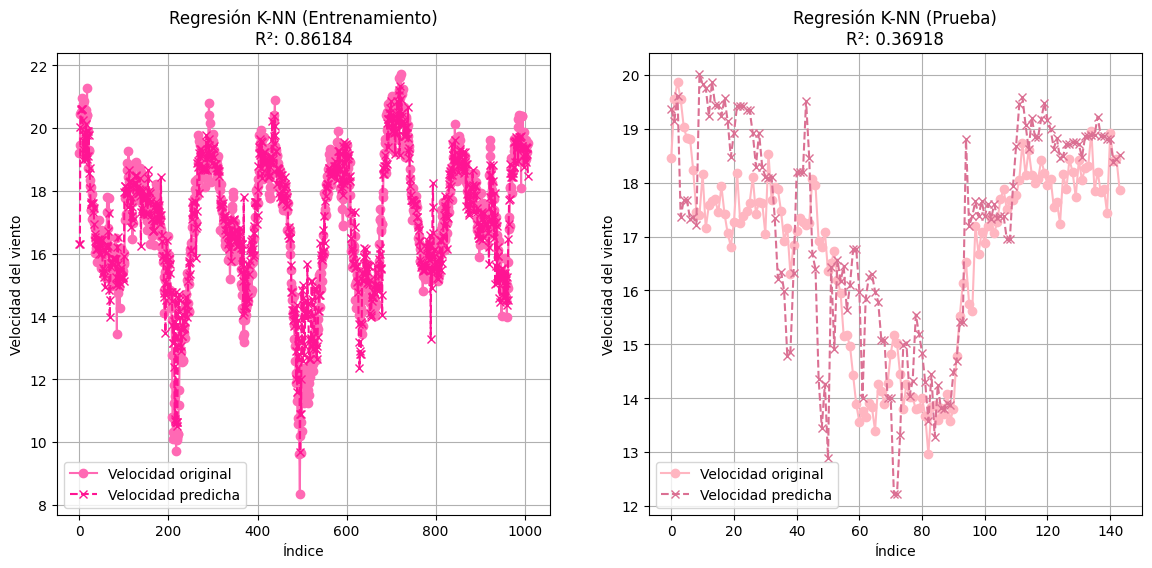

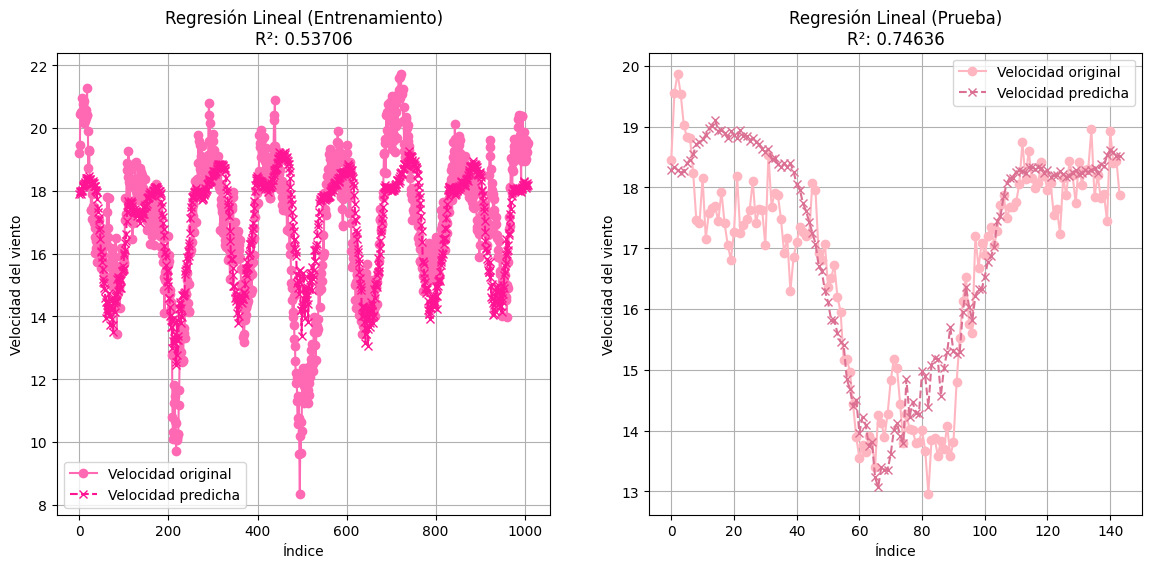

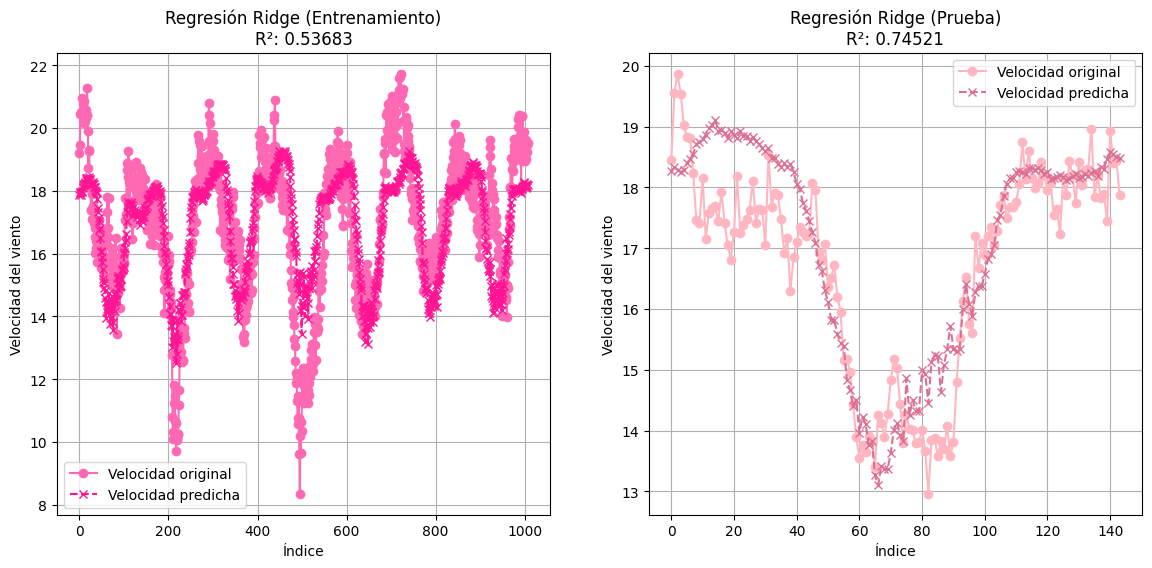

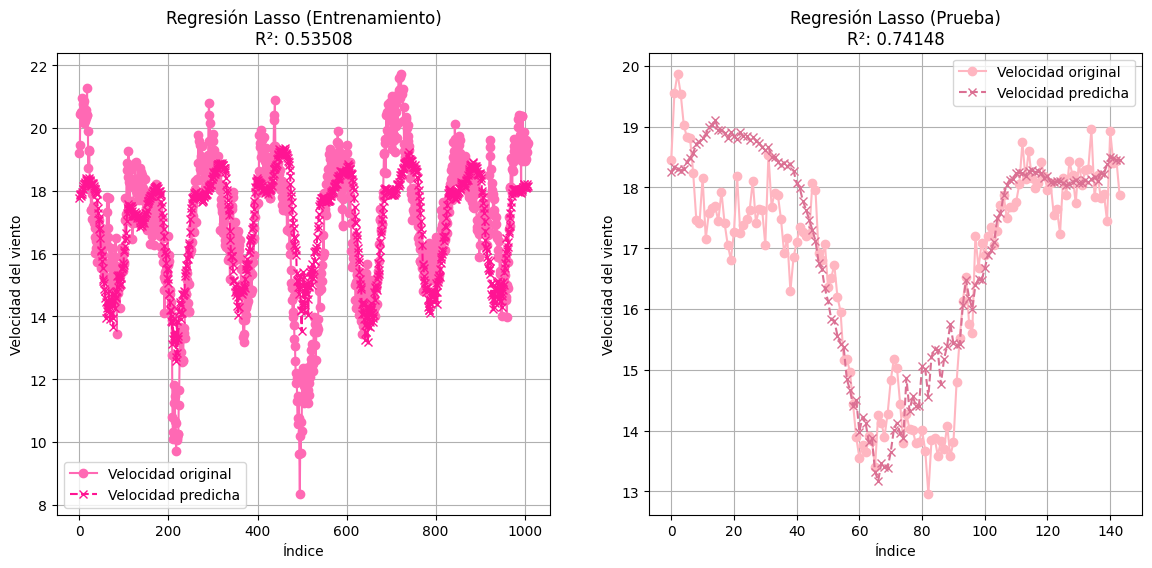

In [ ]:
for i in range(4):
    plt = grafica(mejores[i][0], mejores[i][1], mejores[i][2], mejores[i][3], mejores[i][4])
    plt.show()

Los resultados muestran diferencias claras entre los modelos evaluados para predecir la velocidad del viento. La **Regresión K-NN** tiene un **R² de 0.86184** en el entrenamiento, pero cae a **0.36918** en el conjunto de prueba, indicando **sobreajuste**. En cambio, los **modelos lineales** (Regresión Lineal, Ridge y Lasso) ofrecen un rendimiento más equilibrado, con un ajuste moderado en el entrenamiento (aproximadamente **0.53**) y un desempeño superior en la prueba, con **R² cercanos a 0.74**. Esto sugiere que los modelos lineales son más efectivos para capturar tendencias y generalizar a nuevos datos. En conclusión, aunque K-NN tiene buen desempeño en el entrenamiento, los modelos lineales son las mejores opciones para predecir la velocidad del viento.

## **Modelo 4: Wind speed 80 metros (Sensor 2)**

In [16]:
X4 = data.drop(columns=['Fecha', 'VelViento100m_1', 'VelViento100m_2', 'VelViento80m_1', 'VelViento80m_2', 'VelViento60m', 'DirViento100m', 'DirViento60m'])
y4 = data['VelViento80m_2']


### **Modelos usando ventanas de predicción**

In [ ]:
tabla, mejores = evaluar_modelos(X4, y4)
tabla

,Modelo,MAPE,RMSE,R^2,Ljung-Box p-value,Jarque-Bera p-value
24,Regresión K-NN,6.684306,1.351586,0.377391,8.968552e-32,0.000067
27,Regresión Lasso,4.206317,0.865937,0.744436,4.300009e-63,0.252943
25,Regresión Lineal,4.203377,0.857570,0.749351,7.246420e-60,0.344181
26,Regresión Ridge,4.196624,0.859552,0.748190,6.662610e-61,0.314146


### **Gráficas**

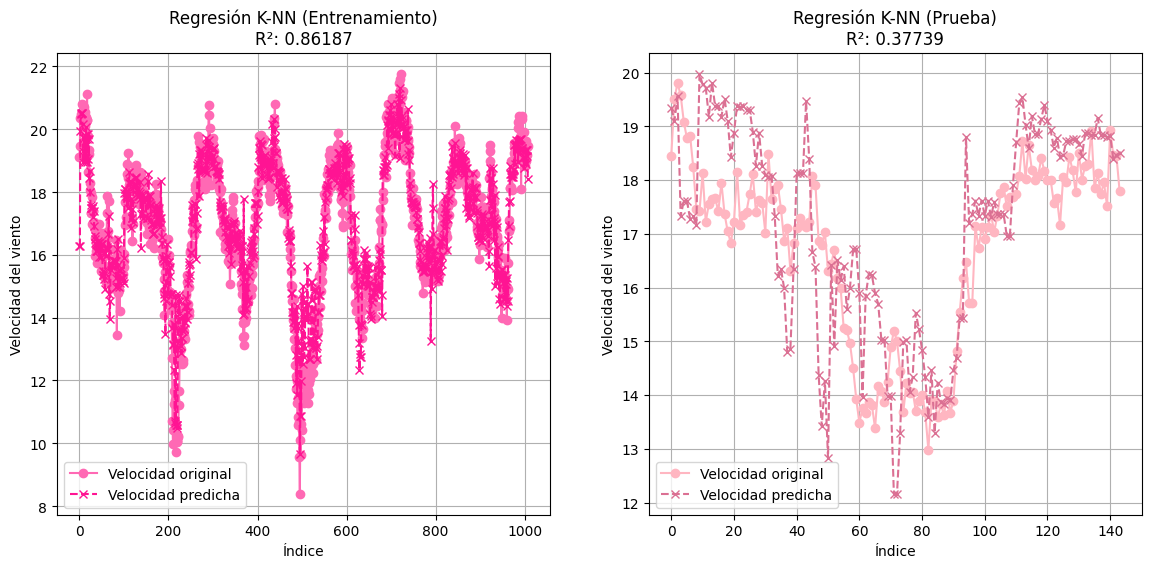

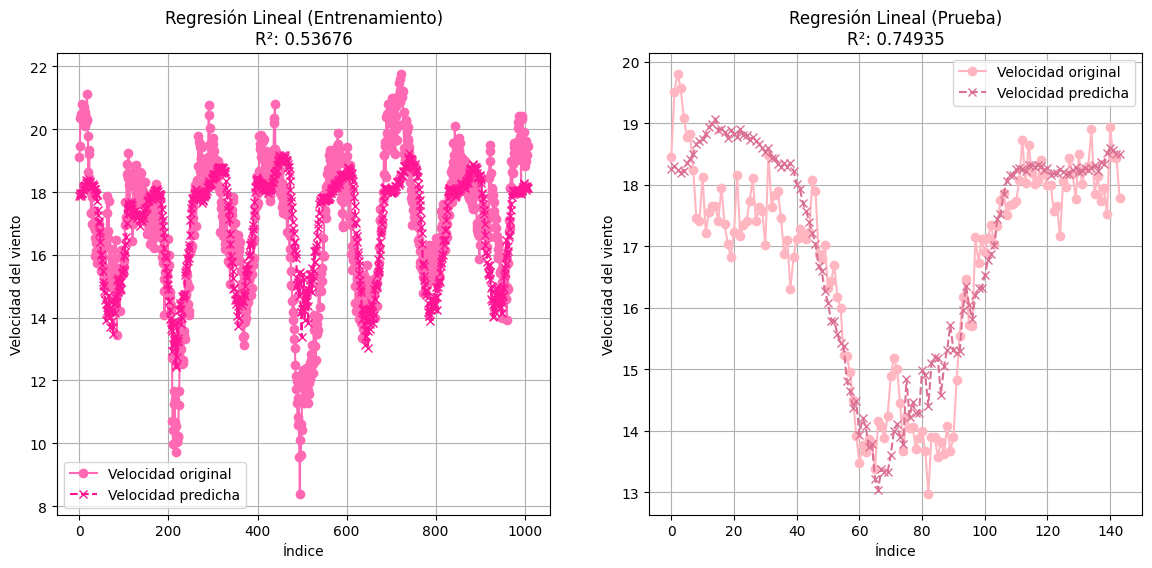

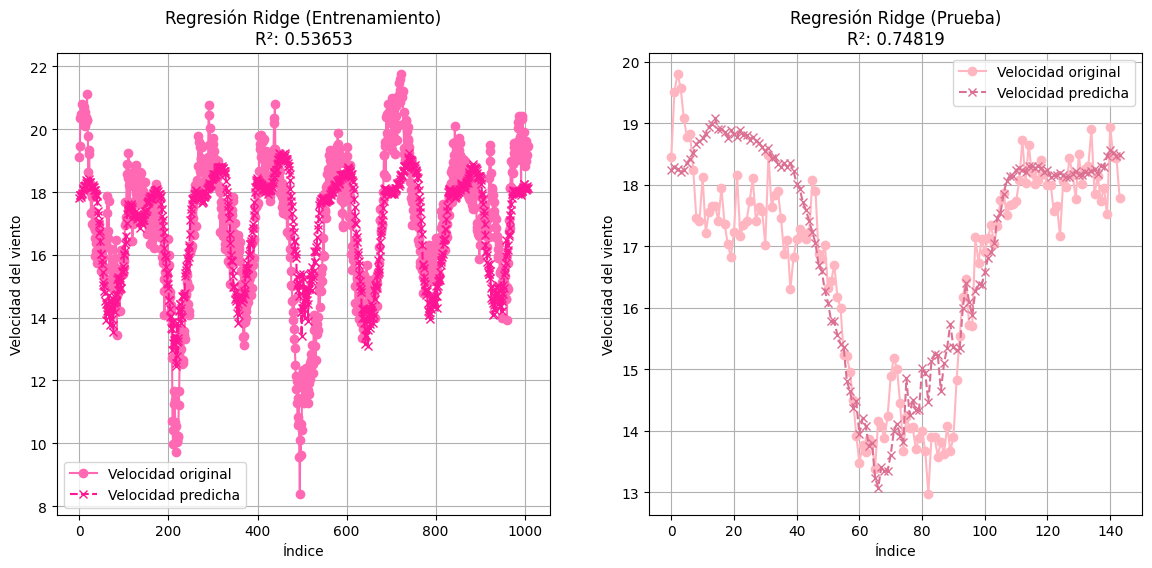

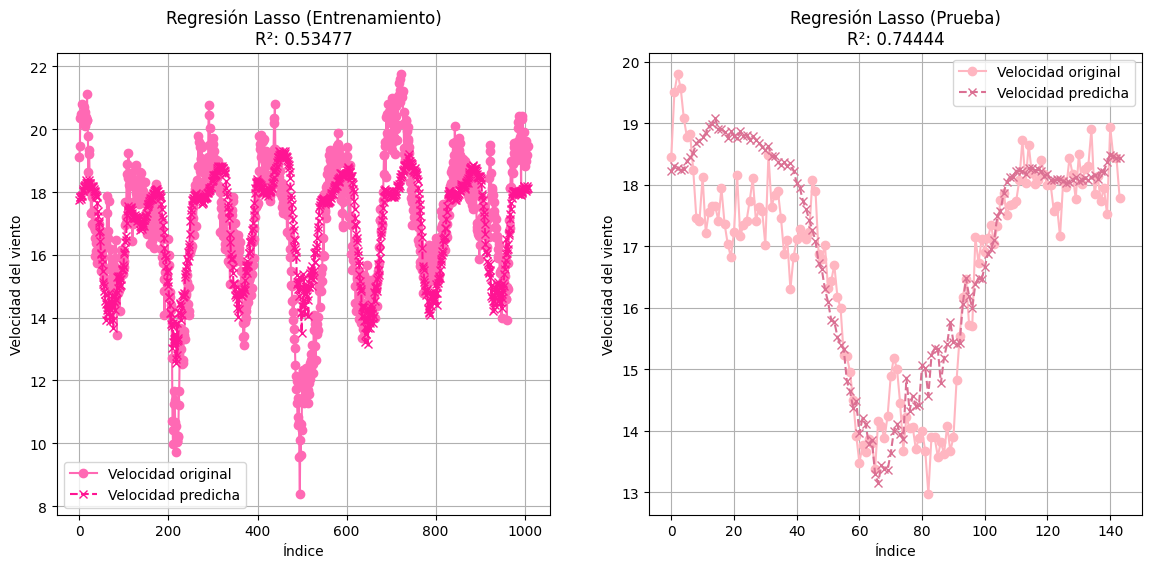

In [ ]:
for i in range(4):
    plt = grafica(mejores[i][0], mejores[i][1], mejores[i][2], mejores[i][3], mejores[i][4])
    plt.show()

En este análisis, se evaluaron los modelos para predecir la **velocidad del viento a 80 metros**. La **Regresión K-NN** mostró un buen desempeño en el conjunto de entrenamiento, con un **R² de 0.86187**, pero su rendimiento en el conjunto de prueba cayó considerablemente a un **R² de 0.37739**, lo que sugiere un **sobreajuste** y una mala generalización. En contraste, los **modelos lineales** (Lineal, Ridge y Lasso) presentaron un rendimiento más equilibrado; aunque su **R² en el entrenamiento** fue menor, alrededor de **0.53**, su desempeño en el conjunto de prueba mejoró significativamente, alcanzando un **R² cercano a 0.74**. Esto indica que, aunque los modelos lineales están menos ajustados en el entrenamiento, generalizan mucho mejor en los datos de prueba. En conclusión, los modelos lineales (Lineal, Ridge y Lasso) ofrecen un mejor equilibrio entre ajuste y generalización en comparación con K-NN, lo que los convierte en la mejor opción para la predicción de la velocidad del viento en este conjunto de datos.

## **Modelo 5: Wind speed 60 metros**

In [15]:
X1 = data.drop(columns=['Fecha', 'VelViento100m_1', 'VelViento100m_2', 'VelViento80m_1', 'VelViento80m_2', 'VelViento60m', 'DirViento80m', 'DirViento100m'])
y1 = data['VelViento60m']


### **Modelos usando ventanas de predicción**

In [ ]:
tabla, mejores = evaluar_modelos(X5, y5)
tabla

,Modelo,MAPE,RMSE,R^2,Ljung-Box p-value,Jarque-Bera p-value
24,Regresión K-NN,6.876112,1.332056,0.349680,8.837886e-33,1.308209e-08
27,Regresión Lasso,4.445645,0.890595,0.709302,8.780533e-59,3.338686e-01
25,Regresión Lineal,4.439774,0.880800,0.715661,1.000130e-55,4.692246e-01
26,Regresión Ridge,4.436869,0.882914,0.714294,1.275099e-56,4.269807e-01


En este análisis, se evaluaron los modelos para predecir la **velocidad del viento a 60 metros**, y los resultados revelan conclusiones significativas. La **Regresión K-NN** obtuvo el peor desempeño, con un **MAPE de 6.87%**, un **RMSE de 1.332056** y un **R² de 0.349680**, lo que indica una alta tasa de error y una incapacidad para capturar los patrones de los datos. En contraste, la **Regresión Lasso** demostró un rendimiento notablemente mejor, con un **MAPE de 4.44%**, un **RMSE de 0.890595** y un **R² de 0.709302**, evidenciando una buena capacidad predictiva y una reducción significativa del error en comparación con K-NN. La **Regresión Lineal** se destacó como el modelo más preciso, logrando un **R² de 0.715661** y un **RMSE de 0.880080**. La **Regresión Ridge** también mostró un rendimiento competitivo, con un **R² de 0.714294** y un **RMSE de 0.882914**, muy cercano al de la Regresión Lineal. En conclusión, los modelos lineales, especialmente la **Regresión Lineal** y la **Regresión Ridge**, ofrecen el mejor rendimiento, logrando un buen equilibrio entre ajuste y generalización, mientras que **K-NN** sigue siendo el modelo menos adecuado para predecir la velocidad del viento a esta altura.

### **Gráfica del mejor modelo**

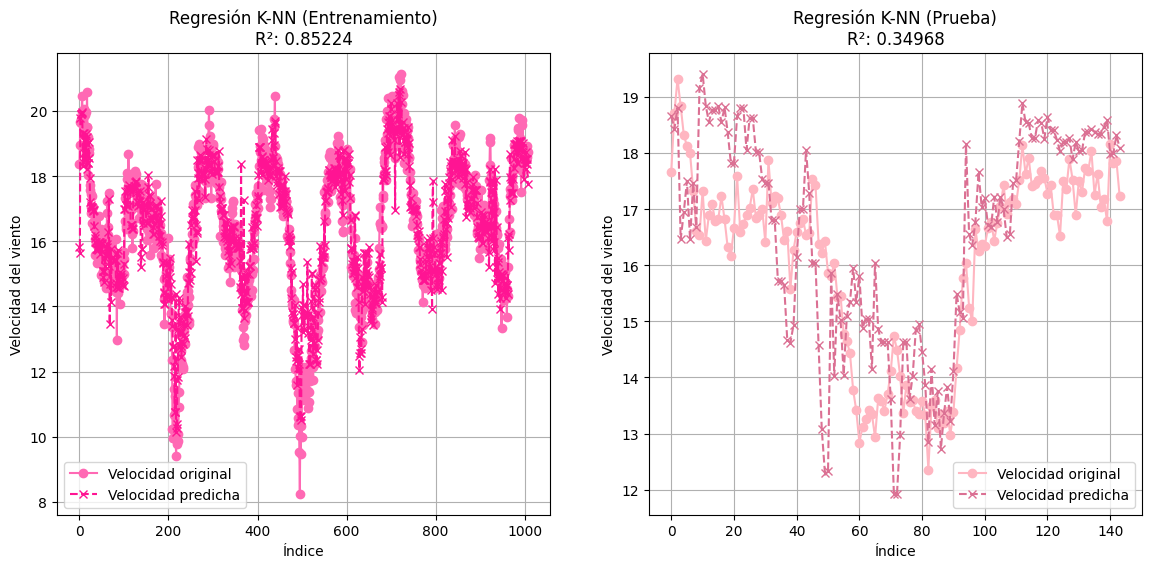

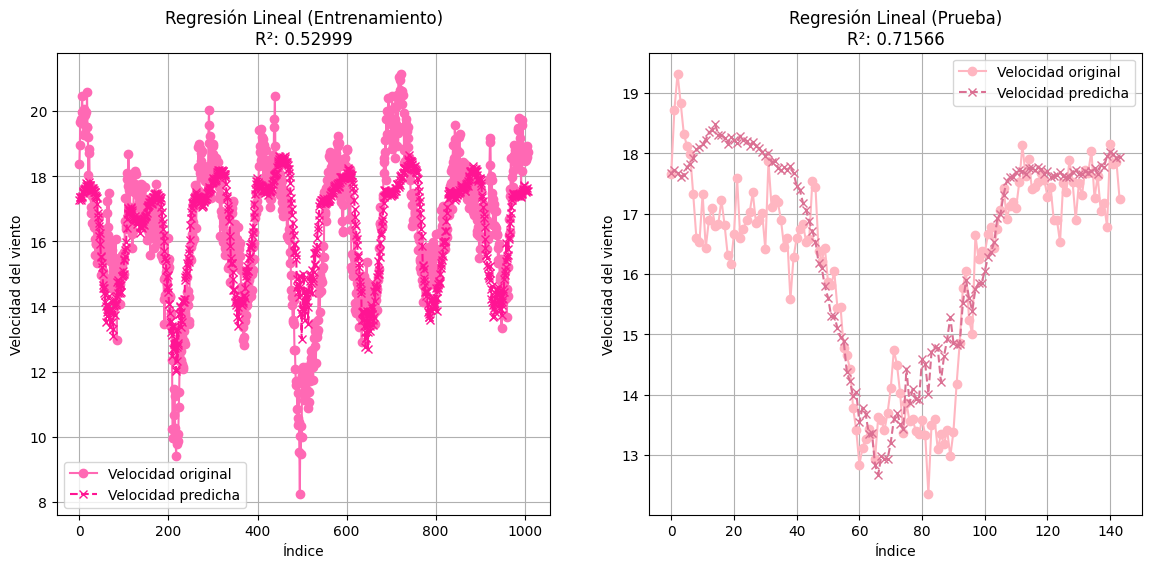

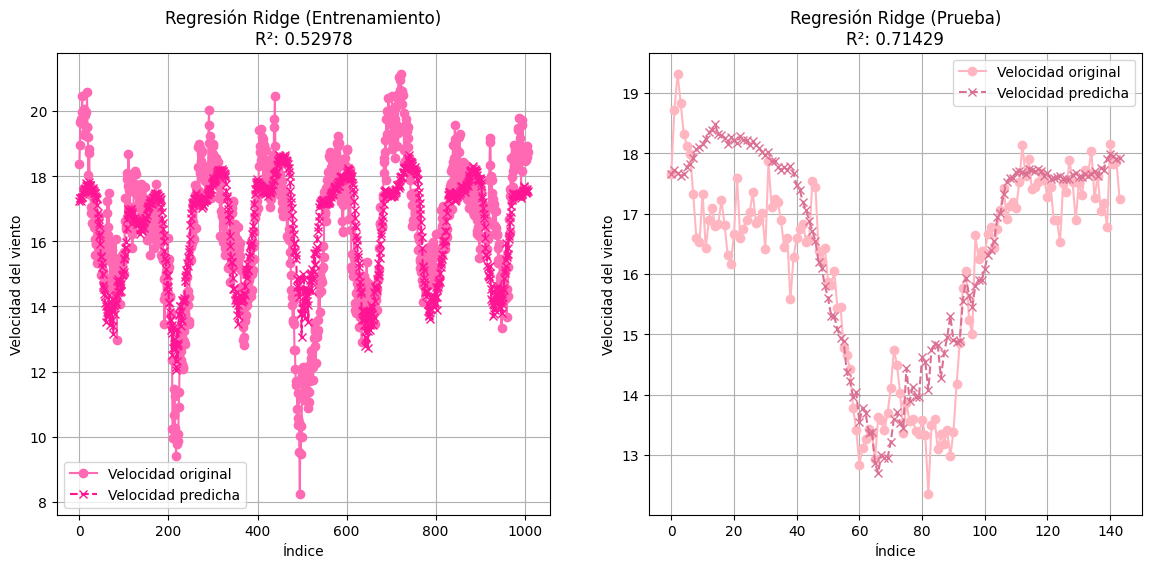

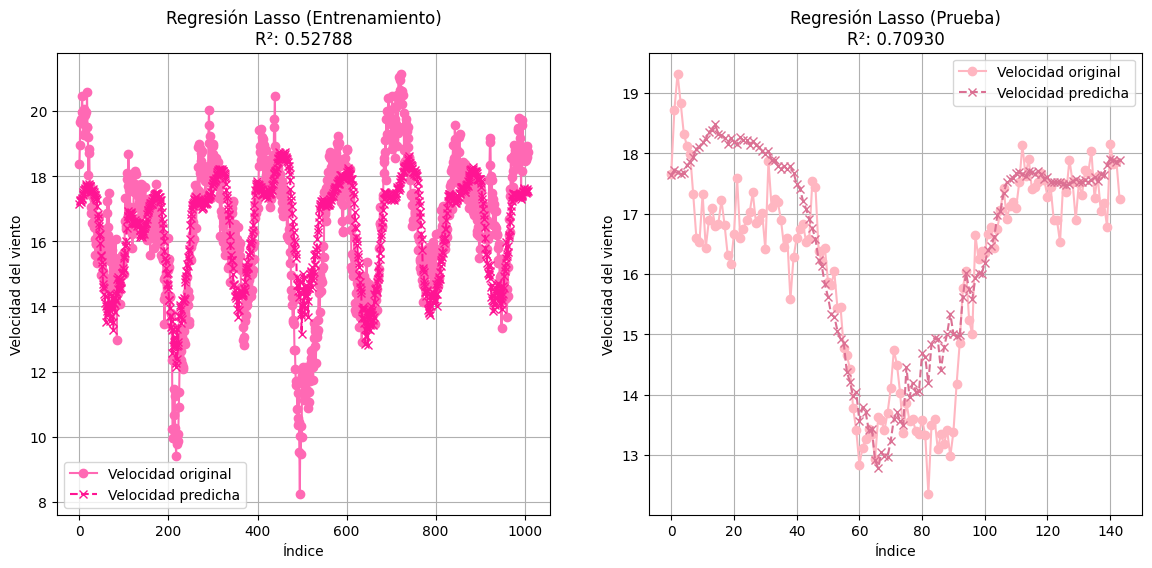

In [ ]:
for i in range(4):
    plt = grafica(mejores[i][0], mejores[i][1], mejores[i][2], mejores[i][3], mejores[i][4])
    plt.show()

Las gráficas que acompañan el análisis de los modelos de predicción de la velocidad del viento a 60 metros revelan varias observaciones clave. En el caso de la **Regresión K-NN**, el modelo muestra un buen ajuste en el entrenamiento con un **R² de 0.85224**, pero cae significativamente en la prueba, con un **R² de 0.34968**, indicando **sobreajuste** y **mala generalización**. La **Regresión Lineal** presenta un **R² de 0.52999** en el entrenamiento y mejora en la prueba con un **R² de 0.71566**, capturando **patrones más precisos**. La **Regresión Ridge** muestra un comportamiento similar, con un **R² de 0.52978** en el entrenamiento y un **R² de 0.71429** en la prueba, confirmando su **buen rendimiento**. Por su parte, la **Regresión Lasso** tiene un **R² de 0.52788** en el entrenamiento y un **R² de 0.70930** en la prueba, siendo competitivo pero ligeramente inferior a los modelos Lineal y Ridge. En conclusión, los **modelos lineales**, especialmente la **Regresión Lineal**, **Ridge** y **Lasso**, ofrecen un **mejor balance entre ajuste y generalización**, con **R² superiores a 0.70** en los datos de prueba, mientras que **K-NN muestra un claro sobreajuste**, siendo el **menos adecuado** para este caso.

## **Conclusión**

Los modelos lineales (Regresión Lineal, Ridge y Lasso) demuestran ser los más apropiados para predecir la velocidad del viento en los diferentes sensores y alturas. Logran un equilibrio entre un ajuste adecuado en los datos de entrenamiento y una buena capacidad de generalización en los datos de prueba. Por otro lado, K-NN, a pesar de su alto rendimiento en entrenamiento, no es adecuado para esta tarea debido a su tendencia a sobreajustarse y su baja capacidad de generalización. Para futuros análisis, esperamos utilizar modelos específicos para series de tiempo y así ver mejor el comportamiento de nuestro conjunto de datos. 